# Swissroads Project: 05 - Logistic classification  

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.


## Aim of this notebook 

The goal of this jupyter notebook, is to perform a logistic regression in order to classify vehicles photographies of the swissroads dataset. The data that will be used are the 2048 high level features extracted for each pictures, using the Inception_v3 convolutional network on the tensoflow hub. 

We will perform a logistic regression without tuning hyperparameters, then we will perform a search grid to tune the model, training the model on the training set and using to the validation set to find the best parameters. And finally, we will evaluate the performance of the model on the test set.

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [2]:
# loading data
# Load data
with np.load('data/train.npz', allow_pickle=False) as npz_file:
    X_tr = npz_file['features']
    y_tr = npz_file['targets']
    names_tr = npz_file['names']
    
with np.load('data/valid.npz', allow_pickle=False) as npz_file:
    X_val = npz_file['features']
    y_val = npz_file['targets']
    names_val = npz_file['names']
    
with np.load('data/test.npz', allow_pickle=False) as npz_file:
    X_te = npz_file['features']
    y_te = npz_file['targets']
    names_te = npz_file['names']
    

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

enc_y_tr = encoder.fit_transform(y_tr.reshape(-1, 1))
enc_y_val = encoder.transform(y_val.reshape(-1, 1))
enc_y_te = encoder.transform(y_te.reshape(-1, 1))

# Logistic regression estimator
logreg_estimator = Pipeline([
    ('scaler', StandardScaler()), # due to standardization and solvers sensitive to rescaling
    ('logreg', LogisticRegression(random_state = 0, max_iter = 1000))
])

In [4]:
logreg_estimator.fit(X_tr,np.ravel(enc_y_tr))

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(max_iter=1000, random_state=0))])

In [5]:
# Report test score
print('validation accuracy of an untuned logistic classifier: {:.2f}%'.format(100*logreg_estimator.score(X_val, np.ravel(enc_y_val))))

validation accuracy of an untuned logistic classifier: 92.09%


Now that we have a first naive classifier, let's try to tune the model and compare the performance. 

For this classifier, we will tune: 
* C: used to tune the regularization; the smaller, the greater the regularization
* class: the type of classification performed: One vs all or multinomial 
* solver: solver to be used according to the type of classification performed

In [6]:
# Grid search with cross-validation
from sklearn.model_selection import GridSearchCV
Cs = np.logspace(-4, 4, num=20)
grids = [{
    'logreg__multi_class': ['ovr'],
    'logreg__solver': ['liblinear'],
    'logreg__C': Cs
}, {
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['saga'],
    'logreg__C': Cs
}]
logreg_gscv = GridSearchCV(logreg_estimator, grids, cv=10, refit=True, return_train_score=True, verbose = 1, n_jobs = -1)

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter('ignore', ConvergenceWarning)

# Fit/evaluate estimator
logreg_gscv.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))

# Collect results in a DataFrame
logreg_results = pd.DataFrame({
    'solver': logreg_gscv.cv_results_['param_logreg__solver'],
    'strategy': logreg_gscv.cv_results_['param_logreg__multi_class'],
    'C': logreg_gscv.cv_results_['param_logreg__C'],
    'mean_tr': logreg_gscv.cv_results_['mean_train_score'],
    'mean_val': logreg_gscv.cv_results_['mean_test_score'],
    'std_val': logreg_gscv.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
logreg_results.sort_values(by='mean_val', ascending=False).head(10)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


,solver,strategy,C,mean_tr,mean_val,std_val
2,liblinear,ovr,0.000695193,0.969502,0.935482,0.028534
26,saga,multinomial,0.0335982,1.000000,0.933159,0.017872
27,saga,multinomial,0.0885867,1.000000,0.930778,0.027063
39,saga,multinomial,10000,1.000000,0.930778,0.030970
38,saga,multinomial,3792.69,1.000000,0.930778,0.030970
36,saga,multinomial,545.559,1.000000,0.930778,0.030970
35,saga,multinomial,206.914,1.000000,0.930778,0.030970
34,saga,multinomial,78.476,1.000000,0.930778,0.030970
33,saga,multinomial,29.7635,1.000000,0.930778,0.030970
32,saga,multinomial,11.2884,1.000000,0.930778,0.030970


In [8]:
best_params = logreg_results.iloc[logreg_results['mean_val'].idxmax(), :]

After fine tuning, the best accurary is achieved with a multinomial strategy and a strong regularization. The mean accuracy on the validation set is 93%.Ze noz fit the logistic regression a final time on the whole training and validation dataset and use it to predict the test set: 

In [9]:
# Logistic regression estimator on whole training + validation sets
logreg_final = Pipeline([
    ('scaler', StandardScaler()), # due to standardization and solvers sensitive to rescaling
    ('logreg', LogisticRegression(C = best_params['C'], multi_class  = best_params['strategy'], solver = best_params['solver'], random_state = 0))
])

In [10]:
logreg_final.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.0006951927961775605, multi_class='ovr',
                                    random_state=0, solver='liblinear'))])

In [11]:
# Report test score

log_reg_accuracy = logreg_final.score(X_te, enc_y_te)
print('Test accuracy of a tuned logistic classifier: {:.2f}%'.format(100*log_reg_accuracy))

Test accuracy of a tuned logistic classifier: 92.00%


We get an accuracy that is slithgly better than with the untuned logistic regression. 


In [12]:
# picking ten random pictures in the test set: 

import random 

randomlist = random.sample(range(50), 10)



In [13]:
random_img = names_te[randomlist]
random_img

array(['motorcycle-0078', 'car-0101', 'van-0041', 'truck-0070',
       'motorcycle-0080', 'motorcycle-0079', 'motorcycle-0082',
       'bike-0102', 'motorcycle-0081', 'motorcycle-0084'], dtype='<U15')

In [14]:
[x + '.png' for x in random_img.tolist()]

['motorcycle-0078.png',
 'car-0101.png',
 'van-0041.png',
 'truck-0070.png',
 'motorcycle-0080.png',
 'motorcycle-0079.png',
 'motorcycle-0082.png',
 'bike-0102.png',
 'motorcycle-0081.png',
 'motorcycle-0084.png']

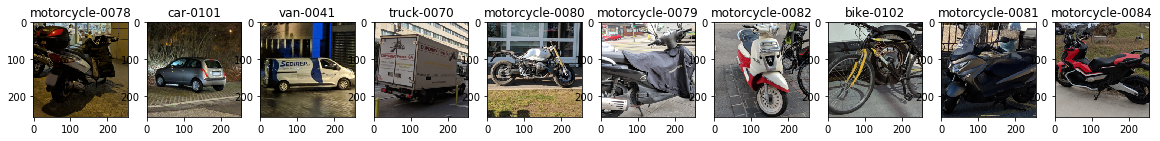

In [15]:
# Plot the chosen images

#load raw data
import PIL.Image as Image
%matplotlib inline
import matplotlib.pyplot as plt

my_path = "swissroads/test"


fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for ax, folder, file in zip(axs, y_te[randomlist].tolist(),random_img.tolist()):
    img =Image.open(os.path.join(my_path,folder, file+'.png'))
    ax.imshow(img)
    ax.set_title(file)

plt.show()


In [16]:
X_te_subset = X_te[randomlist]

In [17]:
proba_classes = pd.DataFrame(logreg_final.predict_proba(X_te_subset)*100,index = random_img, columns = np.unique(y_te).tolist())
proba_classes

,bike,car,motorcycle,other,truck,van
motorcycle-0078,3.087041,7.863748,44.901344,15.747732,8.447738,19.952398
car-0101,6.654643,44.121212,8.378581,13.896292,9.484416,17.464856
van-0041,5.364195,17.329197,6.986738,13.962225,26.556828,29.800818
truck-0070,7.167141,7.036008,8.439315,14.901844,40.431791,22.023900
motorcycle-0080,11.468188,8.994228,39.750432,11.737472,13.472962,14.576717
motorcycle-0079,9.801724,6.035507,40.819752,17.905950,9.793721,15.643347
motorcycle-0082,5.114103,7.780867,42.861313,13.276364,14.888719,16.078635
bike-0102,40.660673,6.927420,12.150222,12.388677,12.031458,15.841549
motorcycle-0081,2.053067,7.571859,40.818029,25.660416,10.707410,13.189220
motorcycle-0084,5.805583,7.436353,41.662857,16.232330,14.230242,14.632636


Finally, we perform a little experiment to see the impact of C, the value of the regularization parameter on the performance of the classifier. As we already mentionned before, the smaller C, the greater is the regularization. 

In [18]:
# Proba with C = 1, 100 amd 1000
logreg_final_C1_ = logreg_final = Pipeline([
    ('scaler', StandardScaler()), # due to standardization and solvers sensitive to rescaling
    ('logreg', LogisticRegression(C = 1, multi_class  = best_params['strategy'], solver = best_params['solver']))
])
logreg_final_C1_.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))

pd.DataFrame(logreg_final_C1_.predict_proba(X_te_subset)*100,index = random_img, columns = np.unique(y_te).tolist())

,bike,car,motorcycle,other,truck,van
motorcycle-0078,0.000571,0.032150,93.734566,0.117793,0.036681,6.078239
car-0101,0.043050,94.836196,0.486737,0.009476,2.930852,1.693689
van-0041,0.020984,3.543114,0.037518,1.814543,47.691665,46.892175
truck-0070,0.051860,0.169609,0.159841,0.055582,96.701193,2.861915
motorcycle-0080,0.094945,0.171020,98.887157,0.615240,0.186326,0.045312
motorcycle-0079,0.007695,0.006065,68.977257,0.792369,0.087495,30.129120
motorcycle-0082,0.050307,0.048158,98.210371,0.109063,0.586730,0.995371
bike-0102,97.270214,0.155668,0.723933,0.641330,0.644420,0.564435
motorcycle-0081,0.000289,0.083620,50.450804,49.371101,0.025877,0.068309
motorcycle-0084,0.012151,0.107953,98.853908,0.077284,0.257443,0.691260


In [19]:
logreg_final_C100_ = logreg_final = Pipeline([
    ('scaler', StandardScaler()), # due to standardization and solvers sensitive to rescaling
    ('logreg', LogisticRegression(C = 100, multi_class  = best_params['strategy'], solver = best_params['solver']))
])
logreg_final_C100_.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))

pd.DataFrame(logreg_final_C100_.predict_proba(X_te_subset)*100,index = random_img, columns = np.unique(y_te).tolist())

,bike,car,motorcycle,other,truck,van
motorcycle-0078,1.343981e-06,0.000298,99.460572,0.000646,0.000463,0.538020
car-0101,1.127402e-03,99.052717,0.030492,0.000006,0.877161,0.038496
van-0041,5.441864e-04,2.912110,0.000615,0.124481,48.660944,48.301306
truck-0070,1.433036e-03,0.002147,0.005164,0.000101,99.870219,0.120936
motorcycle-0080,1.856537e-03,0.002010,99.985322,0.008449,0.002290,0.000072
motorcycle-0079,4.561160e-05,0.000041,68.164512,0.016782,0.000956,31.817663
motorcycle-0082,1.296662e-03,0.000303,99.959237,0.000983,0.008898,0.029283
bike-0102,9.983697e+01,0.004475,0.121045,0.018660,0.011519,0.007327
motorcycle-0081,8.185768e-07,0.002151,50.050878,49.946401,0.000118,0.000451
motorcycle-0084,1.161024e-04,0.001494,99.983000,0.000241,0.001562,0.013587


In [20]:
logreg_final_C0001_ = logreg_final = Pipeline([
    ('scaler', StandardScaler()), # due to standardization and solvers sensitive to rescaling
    ('logreg', LogisticRegression(C = 0.0001, multi_class  = best_params['strategy'], solver = best_params['solver']))
])
logreg_final_C0001_.fit(np.vstack((X_tr, X_val)), np.ravel(np.concatenate((enc_y_tr, enc_y_val))))

pd.DataFrame(logreg_final_C0001_.predict_proba(X_te_subset)*100,index = random_img, columns = np.unique(y_te).tolist())

,bike,car,motorcycle,other,truck,van
motorcycle-0078,9.762567,12.477388,34.092590,15.397949,12.338297,15.931210
car-0101,11.433142,33.142412,11.450244,15.236795,11.877335,16.860071
van-0041,10.682942,18.613988,11.740802,15.460038,21.249214,22.253016
truck-0070,11.725452,11.023481,12.902259,16.264647,28.577319,19.506841
motorcycle-0080,15.744586,12.211927,30.383041,13.417111,13.557106,14.686229
motorcycle-0079,15.329291,11.664980,29.851460,16.572155,12.460933,14.121180
motorcycle-0082,10.468143,10.886038,32.980849,14.924696,14.971795,15.768479
bike-0102,31.654783,10.274753,15.692801,14.259934,13.287348,14.830381
motorcycle-0081,8.096883,11.627564,32.776187,18.416487,14.116892,14.965987
motorcycle-0084,11.764481,10.506894,31.928530,16.186648,14.845666,14.767781


When we increase C, the probabilities are more spreads between the classes. This is as expected, as when we increase C, we give a smaller weight to the penalization function, while with smaller C, we apply more constraints on the weigths. 

Finally, we save teh test accuracy to compare with other methods. 

In [21]:
np.savez('results/04_logistic_regression.npz', test_accuracy=log_reg_accuracy)
